### Install and Import Dependencies

In [25]:
%pip install pandas
%pip install scipy
%pip install matplotlib # might not need
%pip install seaborn
%pip install scikit-learn
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'



Note: you may need to restart the kernel to use updated packages.



In [26]:
# for loading/processing data
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
# For Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# For evaluating Classifier
from sklearn import metrics


### Load Dataset

In [27]:
# Load in the arff file
arff_file = arff.loadarff('data/seismic-bumps.arff')
# Convert to a pandas dataframe
data = pd.DataFrame(arff_file[0])

# Get shape of dataframe: (rows, columns)
print(data.shape)

# Visualize the dataframe
data.sample(5)

(2584, 19)


,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
777,b'a',b'b',b'W',39880.0,342.0,15.0,21.0,b'a',3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2800.0,1000.0,b'0'
1699,b'b',b'b',b'W',37610.0,1004.0,11.0,0.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
941,b'a',b'a',b'N',4790.0,21.0,-94.0,-82.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1197,b'a',b'b',b'N',15640.0,517.0,67.0,72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
2236,b'b',b'b',b'W',54660.0,1287.0,90.0,68.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


### Explore Dataset

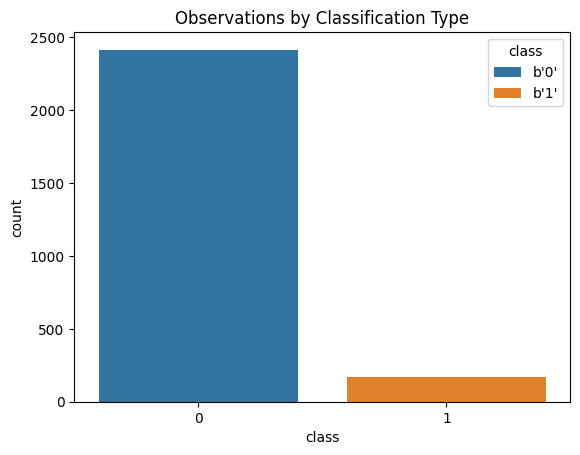

In [28]:
# TODO: add documentation links

# Create a bar chart to plot counts of each class
ax = sns.countplot(x = data['class'], hue=data['class'])

# Add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

### Process/Split Dataset

In [29]:
# TODO: maybe replace labels to something more understandable?

# We only want 2 variables for this classifier so we can visualize in a plot
# The two columns we will get is gpuls and gdenergy
# No data cleaning is needed: this dataset has no nulls

# Also split into input, X, and output, Y
# Shape: (2584, 14)
X = data.iloc[:,[3, 4]]
# Shape: (2584, 1)
Y = data.iloc[:,-1].astype(np.float32)
# Output a few rows of each data
display(X.head(5))
display(Y.head(5))

,genergy,gpuls
0,15180.0,48.0
1,14720.0,33.0
2,8050.0,30.0
3,28820.0,171.0
4,12640.0,57.0


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: class, dtype: float32

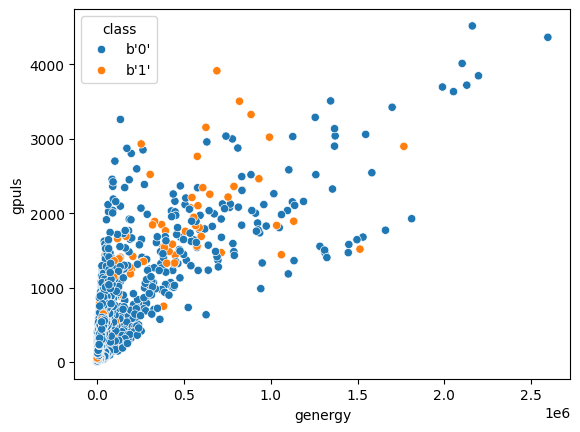

In [30]:
# Plot the input data
ax = sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class')
plt.show()

In [31]:
# Split the data into the train and test set
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

### Random Forest Scikit-learn

### Baseline Model

In [32]:
# Make the classifier. 
# Using default values except:
# Max depth of each tree is 2
# The randomn_state sets the seed for the randomness in bootstrapping the data for each decision tree
classifier = RandomForestClassifier(max_depth=2, random_state=0)

# Train the classifier
classifier.fit(X_train, Y_train)

RandomForestClassifier(max_depth=2, random_state=0)

### Evaluation with Performance Metrics

In [79]:
# Running the test set through the model
# This function outputs the probability for each class
baseline_output = classifier.predict_proba(X_test)
# Peak into a few predicted output probabilities: (probability of class 0, probability of class 1)
print(baseline_output[:10])
# Grab the predicted probabilities for class 1 (We treat this as the positive, minority class)
y_class1_pred_prob = baseline_output[:, 1]

[[0.9378409  0.0621591 ]
 [0.92833102 0.07166898]
 [0.92833102 0.07166898]
 [0.90615054 0.09384946]
 [0.97315698 0.02684302]
 [0.93725957 0.06274043]
 [0.9790075  0.0209925 ]
 [0.9790075  0.0209925 ]
 [0.97182634 0.02817366]
 [0.75653331 0.24346669]]


In [94]:
# Getting the ROC curve and plotting
baseline_fpr, baseline_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob, pos_label=1)

# Finding the AUC score
baseline_roc_auc = metrics.auc(baseline_fpr, baseline_tpr)

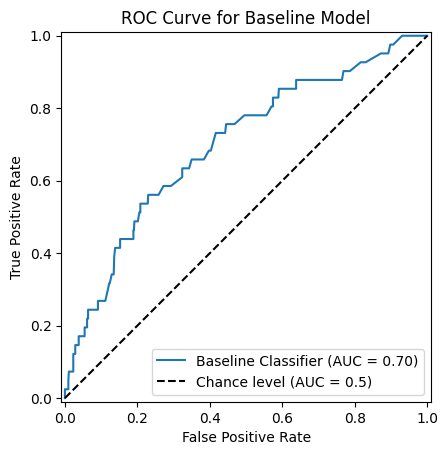

In [102]:
# Plotting the ROC curve
baseline_display_roc = metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob, 
    pos_label=1,
    name='Baseline Classifier', 
    plot_chance_level=True # Plots the ROC curve for a random classifier
)

# Labeling and TItling the Plot
plt.title("ROC Curve for Baseline Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [103]:
# Get precision recall on test set
baseline_precision, baseline_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob)

# Getting the AUC
baseline_pr_auc = metrics.auc(baseline_recall, baseline_precision)

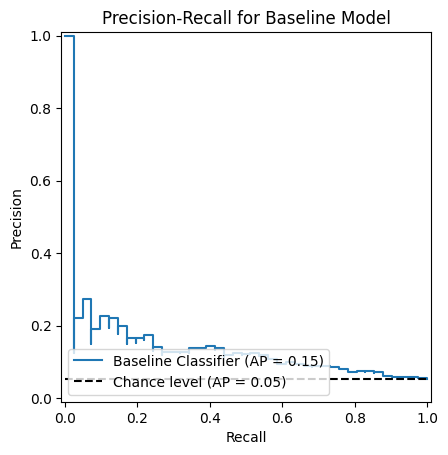

In [104]:
# Plotting the P-R Curve
baseline_display_pr = metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob,
    pos_label = 1,
    name = "Baseline Classifier",
    plot_chance_level=True # Plots the PR curve of a random classifier
)

# Labeling the plot
plt.title("Precision-Recall for Baseline Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Upsampling Techniques

### Random Upsampling

In [105]:
# x='genergy'
# y= 'gpuls'

# genergy_df = data[]
# gpuls_df = data[y]
# display(genergy_df.head())
# display(gpuls_df.head())
# print(genergy_df.shape[0])
# print(gpuls_df.shape[0])
# data.head()
# grouped_by_class = data.groupby('class').count()
b0_df = data[data['class'] == b'0']
b1_df = data[data['class'] == b'1']
b0_num_rows = b0_df.shape[0]
b1_num_rows = b1_df.shape[0]

print('Percentage of b0 data', round((b0_num_rows/len(data)) * 100, 2), '%')
print('Percentage of b1 data', round((b1_num_rows/len(data)) * 100, 2), '%')

# TODO: Sample up the b1 data and then do the same print statments to show the comparison




Percentage of b0 data 93.42 %
Percentage of b1 data 6.58 %


### SMOTE

### OPTIONAL: Borderline SMOTE